In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress

In [42]:
# Step 1: Pull ACS B25070 via API

acs_url = (
    "https://api.census.gov/data/2022/acs/acs5?"
    "get=NAME,"
    "B25070_001E,B25070_007E,B25070_008E,B25070_009E,B25070_010E"
    "&for=zip%20code%20tabulation%20area:*"
)

housing_df = pd.read_json(acs_url)
housing_df.columns = housing_df.iloc[0]
housing_df = housing_df[1:].copy()
housing_df = housing_df.rename(columns={'zip code tabulation area': 'ZCTA'})

# Convert numeric columns to int
num_cols = ['B25070_001E','B25070_007E','B25070_008E','B25070_009E','B25070_010E']
housing_df[num_cols] = housing_df[num_cols].astype(int)

# Calculate % cost-burdened
housing_df['pct_cost_burdened'] = (
    housing_df['B25070_007E'] + housing_df['B25070_008E'] +
    housing_df['B25070_009E'] + housing_df['B25070_010E']
) / housing_df['B25070_001E'] * 100


In [43]:
# Step 2: Pull CDC PLACES data from URL

# Replace this URL with the actual CDC PLACES ZCTA CSV link
places_url = "https://catalog.data.gov/dataset/places-zcta-data-gis-friendly-format-2024-release/resource/06494ad0-8fa5-46e3-a103-59ca5b229730/download/places_zcta_2024.csv"

places_df = pd.read_csv(places_url)

# Rename ZCTA column
places_df = places_df.rename(columns={'ZCTA5': 'ZCTA'})

# Ensure ZCTA column is string and zero-padded
places_df['ZCTA'] = places_df['ZCTA'].astype(str).str.zfill(5)

# Select relevant health outcome columns
places_wide = places_df[['ZCTA', 'PHLTH_CrudePrev', 'MHLTH_CrudePrev', 'DIABETES_CrudePrev']].copy()

# Rename columns for clarity
places_wide = places_wide.rename(columns={
    'PHLTH_CrudePrev': 'poor_physical_health',
    'MHLTH_CrudePrev': 'poor_mental_health',
    'DIABETES_CrudePrev': 'diabetes'
})

# Check the first few rows
print(places_wide.head())


    ZCTA  poor_physical_health  poor_mental_health  diabetes
0  01001                  12.3                16.7      10.7
1  01002                  10.5                18.7       7.9
2  01003                   5.7                26.2       1.1
3  01005                  13.0                17.4      10.3
4  01007                  11.6                15.9       9.5


In [44]:
# Step 3: Filter to Harris County ZCTAs

harris_zips = [
    '77001','77002','77003','77004','77005','77006','77007','77008','77009','77010',
    '77011','77012','77013','77014','77015','77016','77017','77018','77019','77020',
    '77021','77022','77023','77024','77025','77026','77027','77028','77029','77030',
    '77031','77032','77033','77034','77035','77036','77037','77038','77039','77040',
    '77041','77042','77043','77044','77045','77046','77047','77048','77049','77050',
    '77051','77052','77053','77054','77055','77056','77057','77058','77059','77060',
    '77061','77062','77063','77064','77065','77066','77067','77068','77069','77070',
    '77071','77072','77073','77074','77075','77076','77077','77078','77079','77080',
    '77081','77082','77083','77084','77085','77086','77087','77088','77089','77090',
    '77091','77092','77093','77094','77095','77096','77098','77099','77336','77338',
    '77339','77345','77346','77373','77375','77377','77379','77380','77381','77382',
    '77384','77385','77386','77388','77389','77401','77429','77433','77441','77447',
    '77449','77450','77453','77454','77455','77456','77457','77459','77461','77464',
    '77469','77471','77477','77478','77479','77493'
]

housing_df = housing_df[housing_df['ZCTA'].isin(harris_zips)]
places_wide = places_wide[places_wide['ZCTA'].isin(harris_zips)]


In [45]:
# Step 4: Merge ACS + PLACES

merged_df = housing_df.merge(
    places_wide,
    on='ZCTA',
    how='inner'
)


The r-squared is: 0.2097352558801989


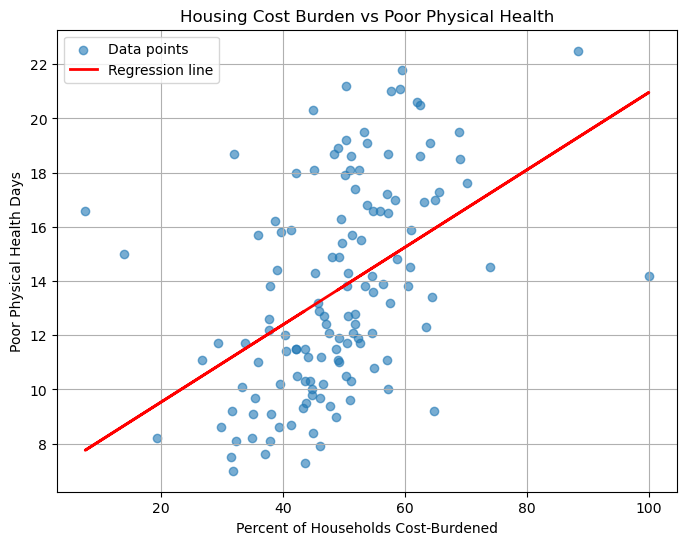

The correlation is statistically significant (P Value = 0.0) and the correlation strength is moderate (R Value = 0.458).
In Houston, ZIP codes with higher housing cost burden tend to experience more poor physical health days, with a statistically significant moderate positive correlation.


In [ ]:
## POOR PHYSICAL HEALTH DAYS vs HOUSING COST BURDEN ANALYSIS

# Merge housing and PLACES on ZCTA to ensure alignment
merged_df = pd.merge(
    housing_df[['ZCTA', 'pct_cost_burdened']],
    places_wide,
    on='ZCTA',
    how='inner'  # only keep ZCTAs present in both
)

# Drop missing values for this analysis
df = merged_df[['pct_cost_burdened', 'poor_physical_health']].dropna()

if df.empty:
    print("No data available after merging and dropping NaNs!")
else:
    X = df['pct_cost_burdened']
    Y = df['poor_physical_health']

    # Compute linear regression
    slope, intercept, r_value, p_value, std_err = linregress(X, Y)

    # Scatter plot with regression line
    plt.figure(figsize=(8,6))
    plt.scatter(X, Y, alpha=0.6, label='Data points')
    plt.plot(X, intercept + slope*X, color='red', linewidth=2, label='Regression line')
    plt.xlabel("Percent of Households Cost-Burdened")
    plt.ylabel("Poor Physical Health Days")
    plt.title("Housing Cost Burden vs Poor Physical Health")
    plt.legend()
    plt.grid(True)
    print(f"The r-squared is: {r_value**2}")
    plt.show()

    # Correlation interpretation
    correlation = r_value  # same as Pearson r
    if p_value < 0.05:
        if abs(correlation) >= 0.7:
            strength = "strong"
        elif abs(correlation) >= 0.3:
            strength = "moderate"
        else:
            strength = "weak"
        print(f"The correlation is statistically significant (P Value = {round(p_value, 3)}) and the correlation strength is {strength} (R Value = {round(r_value, 3)}).")
    else:
        print("The correlation is not statistically significant.")

print("In Houston, ZIP codes with higher housing cost burden tend to experience more poor physical health days, with a statistically significant moderate positive correlation.")
   

The r-squared is: 0.2132127852320311


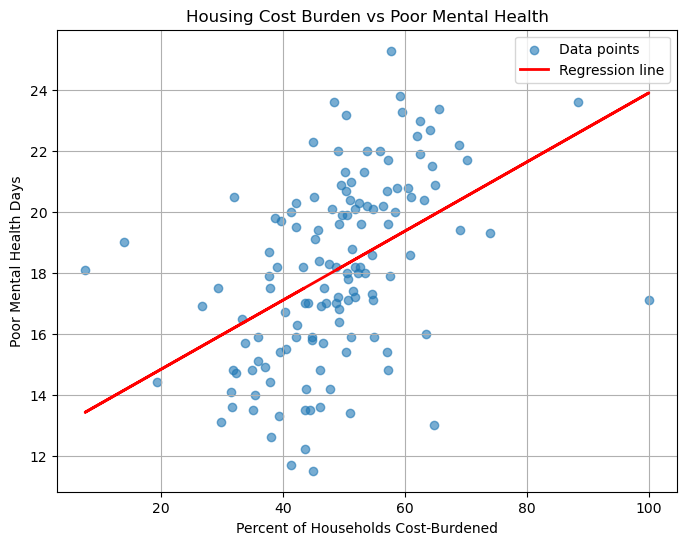

The correlation is statistically significant (P Value = 0.0) and the correlation strength is moderate (R Value = 0.462).
In Houston, ZIP codes with higher housing cost burden tend to experience more poor mental health days, with a statistically significant moderate positive correlation.


In [59]:
## POOR MENTAL HEALTH DAYS vs HOUSING COST BURDEN ANALYSIS

# Drop missing values for this analysis
df = merged_df[['pct_cost_burdened', 'poor_mental_health']].dropna()

if df.empty:
    print("No data available after merging and dropping NaNs!")
else:
    X = df['pct_cost_burdened']
    Y = df['poor_mental_health']

    # Compute linear regression
    slope, intercept, r_value, p_value, std_err = linregress(X, Y)

    # Scatter plot with regression line
    plt.figure(figsize=(8,6))
    plt.scatter(X, Y, alpha=0.6, label='Data points')
    plt.plot(X, intercept + slope*X, color='red', linewidth=2, label='Regression line')
    plt.xlabel("Percent of Households Cost-Burdened")
    plt.ylabel("Poor Mental Health Days")
    plt.title("Housing Cost Burden vs Poor Mental Health")
    plt.legend()
    plt.grid(True)
    print(f"The r-squared is: {r_value**2}")
    plt.show()

    # Correlation interpretation
    correlation = r_value  # same as Pearson r
    if p_value < 0.05:
        if abs(correlation) >= 0.7:
            strength = "strong"
        elif abs(correlation) >= 0.3:
            strength = "moderate"
        else:
            strength = "weak"
        print(f"The correlation is statistically significant (P Value = {round(p_value, 3)}) and the correlation strength is {strength} (R Value = {round(r_value, 3)}).")
    else:
        print("The correlation is not statistically significant.")

print("In Houston, ZIP codes with higher housing cost burden tend to experience more poor mental health days, with a statistically significant moderate positive correlation.")
   

The r-squared is: 0.21862654807058887


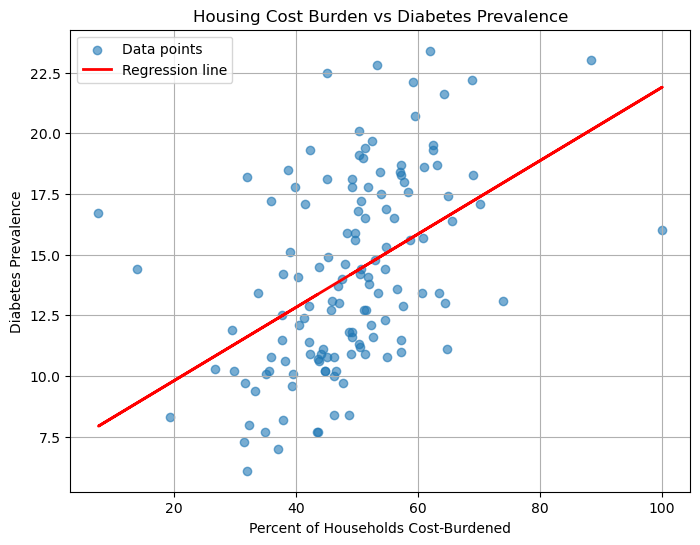

The correlation is statistically significant (P Value = 0.0) and the correlation strength is moderate (R Value = 0.468).
In Houston, ZIP codes with higher housing cost burden tend to experience more diabetes prevalence, with a statistically significant moderate positive correlation.


In [60]:
## DIABETES vs HOUSING COST BURDEN ANALYSIS

# Drop missing values for this analysis
df = merged_df[['pct_cost_burdened', 'diabetes']].dropna()

if df.empty:
    print("No data available after merging and dropping NaNs!")
else:
    X = df['pct_cost_burdened']
    Y = df['diabetes']

    # Compute linear regression
    slope, intercept, r_value, p_value, std_err = linregress(X, Y)

    # Scatter plot with regression line
    plt.figure(figsize=(8,6))
    plt.scatter(X, Y, alpha=0.6, label='Data points')
    plt.plot(X, intercept + slope*X, color='red', linewidth=2, label='Regression line')
    plt.xlabel("Percent of Households Cost-Burdened")
    plt.ylabel("Diabetes Prevalence")
    plt.title("Housing Cost Burden vs Diabetes Prevalence")
    plt.legend()
    plt.grid(True)
    print(f"The r-squared is: {r_value**2}")
    plt.show()

    # Correlation interpretation
    correlation = r_value  # same as Pearson r
    if p_value < 0.05:
        if abs(correlation) >= 0.7:
            strength = "strong"
        elif abs(correlation) >= 0.3:
            strength = "moderate"
        else:
            strength = "weak"
        print(f"The correlation is statistically significant (P Value = {round(p_value, 3)}) and the correlation strength is {strength} (R Value = {round(r_value, 3)}).")
    else:
        print("The correlation is not statistically significant.")

print("In Houston, ZIP codes with higher housing cost burden tend to experience more diabetes prevalence, with a statistically significant moderate positive correlation.")
   